下载和缓存数据集    

在整本书中，我们将下载不同的数据集，并训练和测试模型。 这里我们实现几个函数来方便下载数据。 首先，我们建立字典DATA_HUB， 它可以将数据集名称的字符串映射到数据集相关的二元组上， 这个二元组包含数据集的url和验证文件完整性的sha-1密钥。 所有类似的数据集都托管在地址为DATA_URL的站点上

In [2]:
import hashlib
import os
import tarfile
import zipfile
import requests

#@save
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

下面的download函数用来下载数据集， 将数据集缓存在本地目录（默认情况下为../data）中， 并返回下载文件的名称。 如果缓存目录中已经存在此数据集文件，并且其sha-1与存储在DATA_HUB中的相匹配， 我们将使用缓存的文件，以避免重复的下载

这个函数实现了智能的数据集下载机制：
    通过检查本地缓存避免重复下载
    使用SHA-1哈希校验确保文件完整性
    文件不存在或校验失败时才会从网络重新下载
    提供统一的数据集访问接口，隐藏了底层的下载和缓存细节

In [3]:
def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]

    # 创建缓存目录
    os.makedirs(cache_dir, exist_ok=True)

    # 获取文件路径，与缓存目录拼接成完整的文件路径
    fname = os.path.join(cache_dir, url.split('/')[-1])

    # 检查缓存是否有效

    # 检查文件是否已存在于缓存目录
    # 如果存在，计算文件的SHA-1哈希值
    # 分块读取文件(1MB一块)以处理大文件
    # 如果计算得到的哈希值与预期相符，说明缓存有效，直接返回文件名
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存

    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

同时实现另外两个实用函数

一个将下载并解压缩一个zip或tar文件， 另一个是将本书中使用的所有数据集从DATA_HUB下载到缓存目录中。

In [ ]:
def download_extract(name, folder=None):  #@save
    """下载并解压zip/tar文件"""
    fname = download(name) # 调用之前定义的 download 函数下载数据文件，获取文件路径

    # 获取文件所在的目录 base_dir
    # 获取文件名(不含扩展名)和扩展名
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)

    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'

    # 解压缩文件到指定目录
    fp.extractall(base_dir)
    # 返回解压后的目录路径
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  #@save
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

kaggle 房价预测
https://www.kaggle.com/c/house-prices-advanced-regression-techniques


访问和读取数据集

!pip
这是一个 shell 命令前缀，表示在系统 shell 中执行命令
在一个独立的子进程中运行，与当前 Python 解释器分离
安装的包可能不会立即在当前 notebook 会话中可用，可能需要重启内核
示例：!pip install pandas

%pip
这是一个 IPython 魔法命令
直接在当前 Python 解释器环境中运行
自动检测当前环境，确保包被安装到正确的环境中
通常不需要重启内核就能使用新安装的包
示例：%pip install pandas

In [4]:
# 如果没有安装pandas，请取消下一行的注释
# !pip install pandas

import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

用定义的脚本下载并缓存数据集

In [ ]:
DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

# '585e9cc93e70b39160e7921475f9bcd7d31219ce'
# 这是一个40位的十六进制字符串，代表文件的SHA-1哈希值，用于验证下载文件的完整性和真实性

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

我们使用pandas分别加载包含训练数据和测试数据的两个CSV文件。

In [18]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


前四个和最后两个特征，以及相应标签（房价）

iloc使用数字索引来定位数据，格式为DataFrame.iloc[row_indexer, column_indexer]

In [19]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


在每个样本中，第一个特征是ID， 这有助于模型识别每个训练样本。 虽然这很方便，但它不携带任何用于预测的信息。 因此，在将数据提供给模型之前，我们将其从数据集中删除

pandas.concat() 是一个用于连接或合并多个pandas对象（如DataFrame或Series）的函数

pandas.concat(objs, axis=0, join='outer', ignore_index=False, keys=None, 
              levels=None, names=None, verify_integrity=False, sort=False, copy=True)
objs: 需要连接的pandas对象的序列或字典
axis: 连接的轴向，0表示垂直方向连接（按行），1表示水平方向连接（按列）
join: 连接方式，'outer'保留所有键值，'inner'只使用交集
ignore_index: 是否忽略原有索引并重新生成


In [21]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

# train_data.iloc[:, 1:-1]: 选择训练数据中除第一列和最后一列的所有列
# 第一列是ID（不携带预测信息）
# 最后一列是目标值（房价）

# test_data.iloc[:, 1:]: 选择测试数据中除第一列的所有列
# 第一列是ID（不携带预测信息）
# 测试数据没有目标值（房价）列

# pd.concat((...)): 垂直方向连接这两个数据集
# 默认axis=0，表示按行连接
# 生成一个新的DataFrame，包含所有特征列，但不包含ID列和房价列

# 将训练数据和测试数据合并，用于统一进行数据预处理，在完成之后再分别存储到两个数据中

数据预处理

将所有缺失的值替换为相应特征的平均值。然后，为了将所有特征放在一个共同的尺度上， 我们通过将特征重新缩放到零均值和单位方差来标准化数据

In [22]:
# 若无法获得测试数据，则可根据训练数据计算均值和标准差

# all_features.dtypes 获取每列的数据类型
# all_features.dtypes != 'object' 创建一个布尔数组，标识非对象（即数值）类型的列
# .index 获取这些数值类型列的索引名称
# 结果是包含所有数值特征名称的索引对象
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index

# 数据的标准化：
# 选择所有的数值特征列
# 使用.apply()方法对每一列应用一个函数
# 该函数是一个lambda表达式：lambda x: (x - x.mean()) / (x.std())
# 对每一列计算Z-分数标准化：将数据减去均值后除以标准差
# 这样处理后，每一列的数据都具有零均值和单位方差
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))

# 在标准化数据之后，所有均值消失，因此我们可以将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

处理离散值

独热编码是处理分类数据的标准方法，将分类变量转换为一种适合机器学习算法使用的数值表示形式。
原理
    对于每个分类特征，创建N个新列，其中N是该特征的唯一值数量
    对于每个样本，在相应的类别列中标记为1，其余列标记为0
    删除原始的分类特征列
该函数会自动检测非数值类型的列(即dtype='object'的列)，也会处理数值型的分类特征(如红=1, 绿=2, 蓝=3)

In [27]:
# “Dummy_na=True”将“na”（缺失值）视为有效的特征值，并为其创建指示符特征
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 330)

通过values属性，我们可以 从pandas格式中提取NumPy格式，并将其转换为张量表示用于训练

In [28]:
n_train = train_data.shape[0]

numpy_features = all_features.values.astype(np.float32)
train_features = torch.from_numpy(numpy_features[:n_train])
test_features = torch.from_numpy(numpy_features[n_train:])
# train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
# test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
# 会报错显示数组中仍有混合类型数据
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

训练

首先训练一个带有平方损失的线性模型，线性模型能提供一种健全性检查，线性模型将作为基线（baseline）模型， 让我们直观地知道最好的模型有超出简单的模型多少。

In [29]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features,1))
    return net

因为我们更关心的是相对误差而不是绝对误差，因此可以用价格预测的对数来衡量差异

In [30]:
# 对数均方根误差
def log_rmse(net, features, labels):
    # torch.clamp 函数用于限制输入张量的值在指定范围内

    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))

    # .item() 将张量转换为Python数值
    return rmse.item()

训练函数借助Adam优化器，Adam优化器主要吸引力在于它对初始学习率不怎么敏感

Adam (Adaptive Moment Estimation) 是一种自适应学习率的优化算法，结合了动量法和RMSProp的优点。
核心特点

自适应学习率:
    为每个参数计算不同的学习率
    根据梯度的历史大小自动调整学习率

动量机制:
    保持方向惯性，有助于快速通过平坦区域
    减少震荡，更快收敛

二阶动量:
    计算梯度平方的指数移动平均值
    用于归一化梯度，使稀疏特征也能得到合理的更新

In [31]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    # 将模型参数、学习率和权重衰减作为参数
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)

    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()

        # 每一轮结束后计算并记录训练集上的log_rmse
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))

    return train_ls, test_ls

K折交叉验证

In [32]:
# 在K折交叉验证过程中返回第i折的数据
# 它选择第i个切片作为验证数据，其余部分作为训练数据
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    # 遍历所有折
    for j in range(k):
        # 计算当前折的索引范围
        # slice用于创建一个表示切片范围的对象
        # 通过创建一个slice对象，可以在多个地方重复使用相同的切片操作
        idx = slice(j * fold_size, (j + 1) * fold_size)

        # 获取当前折的数据
        X_part, y_part = X[idx, :], y[idx]
        # 如果当前折是第i折，则将其作为验证数据
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part # 第一部分
        else:
            X_train = torch.cat([X_train, X_part], 0) #合并后续训练数据
            y_train = torch.cat([y_train, y_part], 0)

    return X_train, y_train, X_valid, y_valid

In [ ]:
# 在k折交叉验证中训练k次后，返回训练和验证误差的平均值
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):

    train_l_sum, valid_l_sum = 0, 0
    # 训练k次
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]

        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
                     
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

模型选择

找到一组调优的超参数可能需要时间，这取决于一个人优化了多少变量。 有了足够大的数据集和合理设置的超参数，K折交叉验证往往对多次测试具有相当的稳定性。 然而，如果我们尝试了不合理的超参数，我们可能会发现验证效果不再代表真正的误差。

有时一组超参数的训练误差可能非常低，但k折交叉验证的误差要高得多， 这表明模型过拟合了。 在整个训练过程中，我们希望监控训练误差和验证误差这两个数字。 较少的过拟合可能表明现有数据可以支撑一个更强大的模型， 较大的过拟合可能意味着我们可以通过正则化技术来获益

折1，训练log rmse0.136809, 验证log rmse0.149339
折2，训练log rmse0.138051, 验证log rmse0.123023
折3，训练log rmse0.134066, 验证log rmse0.161611
折4，训练log rmse0.132492, 验证log rmse0.155141
折5，训练log rmse0.137433, 验证log rmse0.122927
折6，训练log rmse0.138595, 验证log rmse0.130408
折7，训练log rmse0.135891, 验证log rmse0.159414
折8，训练log rmse0.133862, 验证log rmse0.175792
8-折验证: 平均训练log rmse: 0.135900, 平均验证log rmse: 0.147207


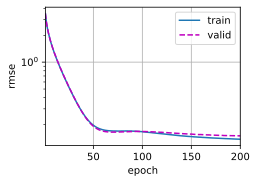

In [44]:
k, num_epochs, lr, weight_decay, batch_size = 8, 200, 6, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

使用所有数据对其进行训练，通过这种方式获得的模型可以应用于测试集。 将预测保存在CSV文件中可以简化将结果上传到Kaggle的过程

In [ ]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):

    net = get_net()

    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)

    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')

    print(f'训练log rmse：{float(train_ls[-1]):f}')

    # 将网络应用于测试集。
    preds = net(test_features).detach().numpy()
    
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

检验测试集上的预测与K倍交叉验证过程中的预测相似

训练log rmse：0.132961


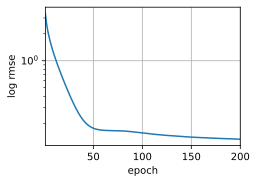

In [45]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)